G203-47 is another wd+dm binary with a cool white dwarf. 15 day period so might be tricky to spot with TESS

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from scipy.interpolate import interp1d


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [36]:
# tic = 219085795
star = lk.search_lightcurve('TIC219085795')
star

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 24,2020,SPOC,120,219085795,0.0
1,TESS Sector 24,2020,TESS-SPOC,1800,219085795,0.0
2,TESS Sector 24,2020,QLP,1800,219085795,0.0
3,TESS Sector 25,2020,SPOC,120,219085795,0.0
4,TESS Sector 25,2020,TESS-SPOC,1800,219085795,0.0
5,TESS Sector 25,2020,QLP,1800,219085795,0.0
...,...,...,...,...,...,...
12,TESS Sector 51,2022,SPOC,20,219085795,0.0
13,TESS Sector 51,2022,SPOC,120,219085795,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

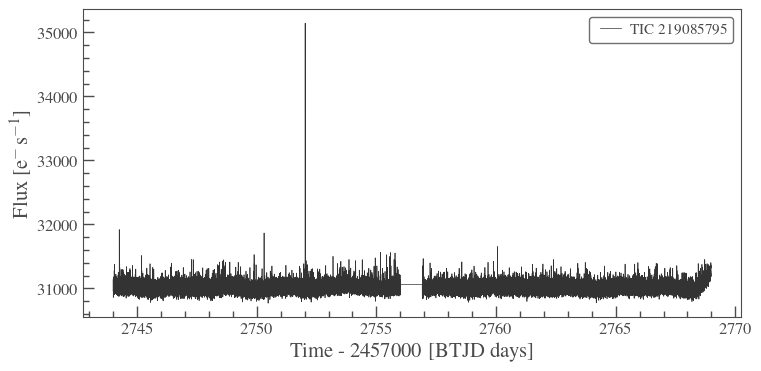

In [37]:
lc = star[17].download(download_dir='data/') 
lc.plot()

In [38]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

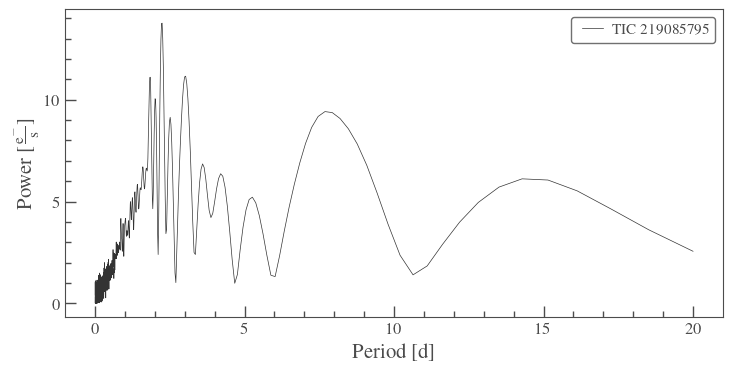

In [39]:
pg.plot()

Need to use wotan to combine all 2min data. Next step, make a spectrum a la GJ207.1. Sebastain's MUSS sample has parameters. L980-5 has similar mass and Teff

In [40]:
prox = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/L-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v24_const-res-sed.fits', 1)
dmw, dmf = prox['WAVELENGTH'], prox['FLUX']

In [41]:
# phx = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ163/hlsp_muscles_model_phx_gj163_na_v24_component-spec.fits', 1)
# pw, pf = phx['WAVELENGTH'], phx['FLUX']
# norm = prox['NORMFAC'][-1]
# pf = pf * norm

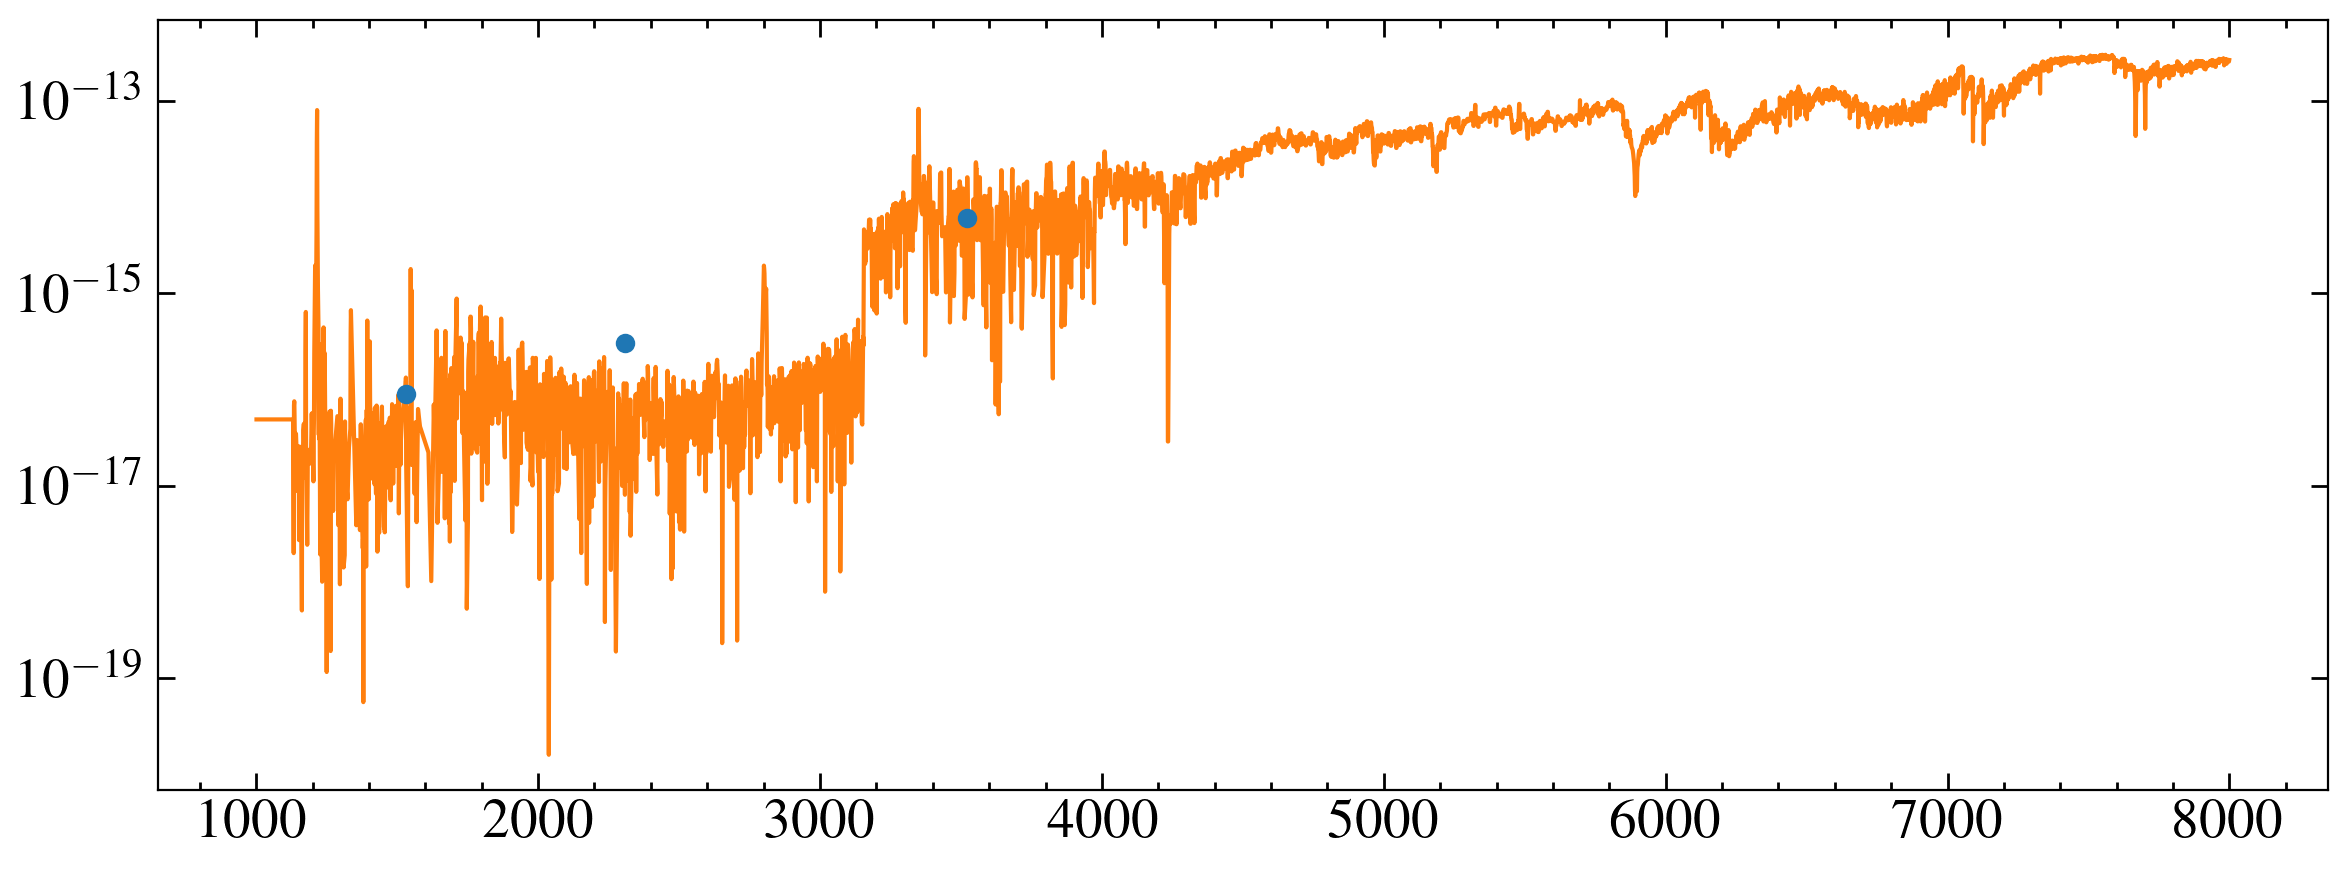

In [78]:
fig, ax = plt.subplots()

mask = (dmw >1000) & (dmw < 8000) & (dmf > 0)
dmw1, dmf1 = dmw[mask], dmf[mask]

d_gj163 = 1000/66.0714
d_l980 = 1000/74.5644
d_g203 = 1000/131.60
# print(d_gj163, d_g203)

scale = (d_l980/d_g203)**2

#u, nuv and fuv photometry from vizer
phot_w = np.array([1.53e-1,  2.31e-1, 3.52e-1])*u.um
phot_f = np.array([7.00e-6, 54.5e-6, 2.50e-3])*u.Jy
phot_e = np.array([2.70e-6, 4.8e-6, 0.01e-3])*u.Jy

phot_e = phot_e/phot_f
phot_f = phot_f.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(phot_w))
phot_e = phot_f*phot_e
phot_w = phot_w.to(u.AA)

ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')


ax.plot(dmw1, dmf1*scale)

# pmask = (pw > 1300) & (pw < 6000)
# ax.plot(pw[pmask], pf[pmask]*scale, zorder=-1)

ax.set_yscale('log')


Looks like the options for proxy spectra aren't great. PHX model and wd?

In [79]:
import prepare_phoenix_svo as pp


G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.2714
# teff = 5715
teff = 3279
teff_e = 64
# radius = 1.79
radius = 0.286
distance = 1000/134.5971
save_path = 'models/'
star = 'G204-47'
g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc, 'Teff_e':teff_e}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

# pdata = Table.read('models/Wasp_63_phoenix_interpolated.ecsv')
# pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']

In [80]:
pdata = Table.read('models/G204-47_phoenix_interpolated.ecsv')
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
# plt.plot(pw, pf*normfac)
# plt.yscale('log')
# plt.xscale('log')

Make model with wd, phoenix and mgii lines?

In [81]:
path = '/media/david/2tb_ext_hd/hddata/carmenes_binary/'
mods = glob.glob('{}models_1628872352/koester2/*.dat.txt'.format(path))
mods

['/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05250_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05500_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05750_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06250_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06500_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06750_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da07000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da07250_800.dk.

In [82]:
rwd = 0.0127*u.Rsun
wd_scale = (rwd.to(u.m)/(d_g203*u.pc).to(u.m))**2


[8.96470249e-17 3.06191581e-16 6.04888579e-15] erg / (Angstrom cm2 s) [3.45781382e-17 2.69673319e-17 2.41955432e-17] erg / (Angstrom cm2 s)


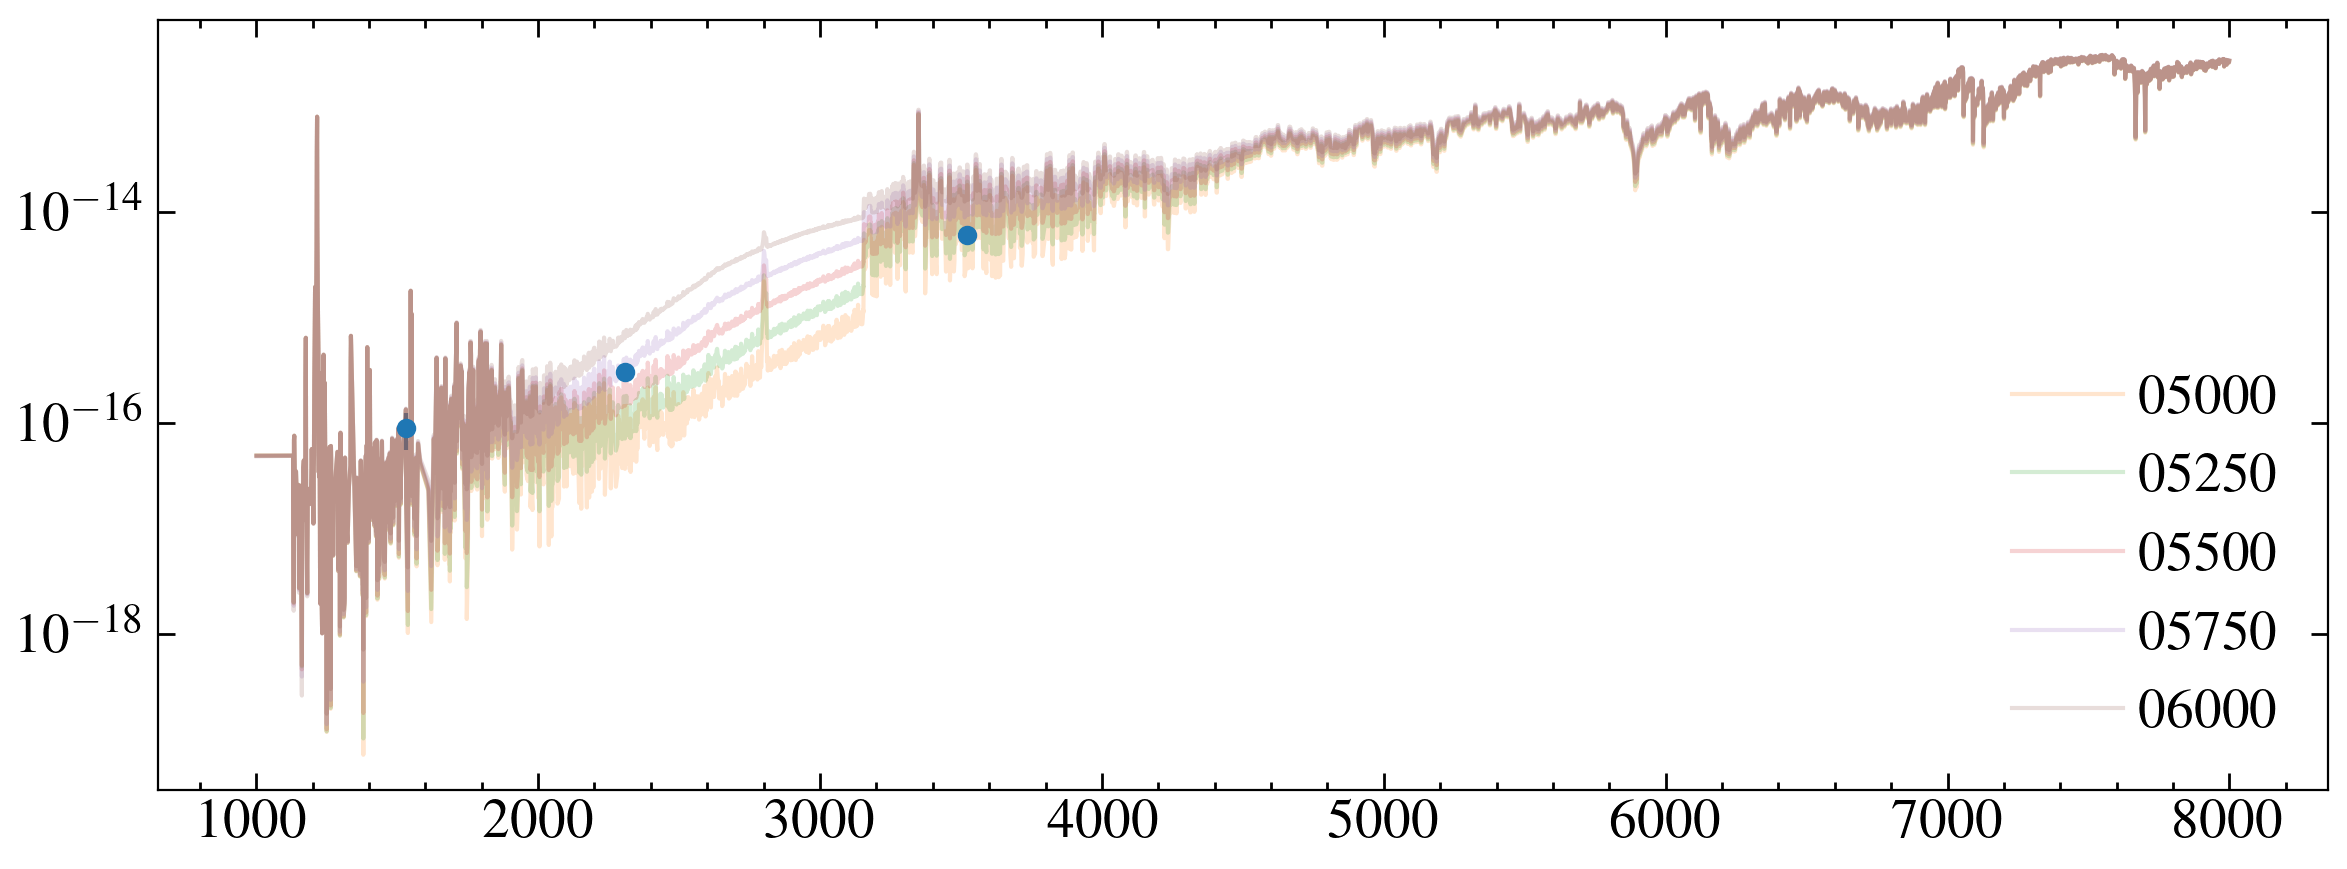

In [83]:
fig, ax = plt.subplots()

pmask = (pw > 1300) & (pw < 6000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')
print(phot_f, phot_e)



# ax.plot(pwi, pfi)

for model in mods[0:5]:
    tmod = os.path.split(model)[1][2:7]
    mw, mf = np.loadtxt(model, unpack=True)
    wdmask =  (mw > 1300) & (mw < 6000)
    mw, mf = mw[wdmask], mf[wdmask]*wd_scale
    mfi = interp1d(mw, mf, fill_value='extrapolate')(pwi)
    mfi = mfi+pfi
    mfi = interp1d(mw, mf, fill_value='extrapolate')(dmw1)
    mfi = mfi+(dmf1*scale)
    
    
    ax.plot(dmw1, mfi, alpha=0.2, label = tmod)
    # ax.plot(mw[wdmask], mf[wdmask]*wd_scale, alpha=0.2)
# ax.plot(dmw1, dmf1*scale)
ax.legend()

ax.set_yscale('log')


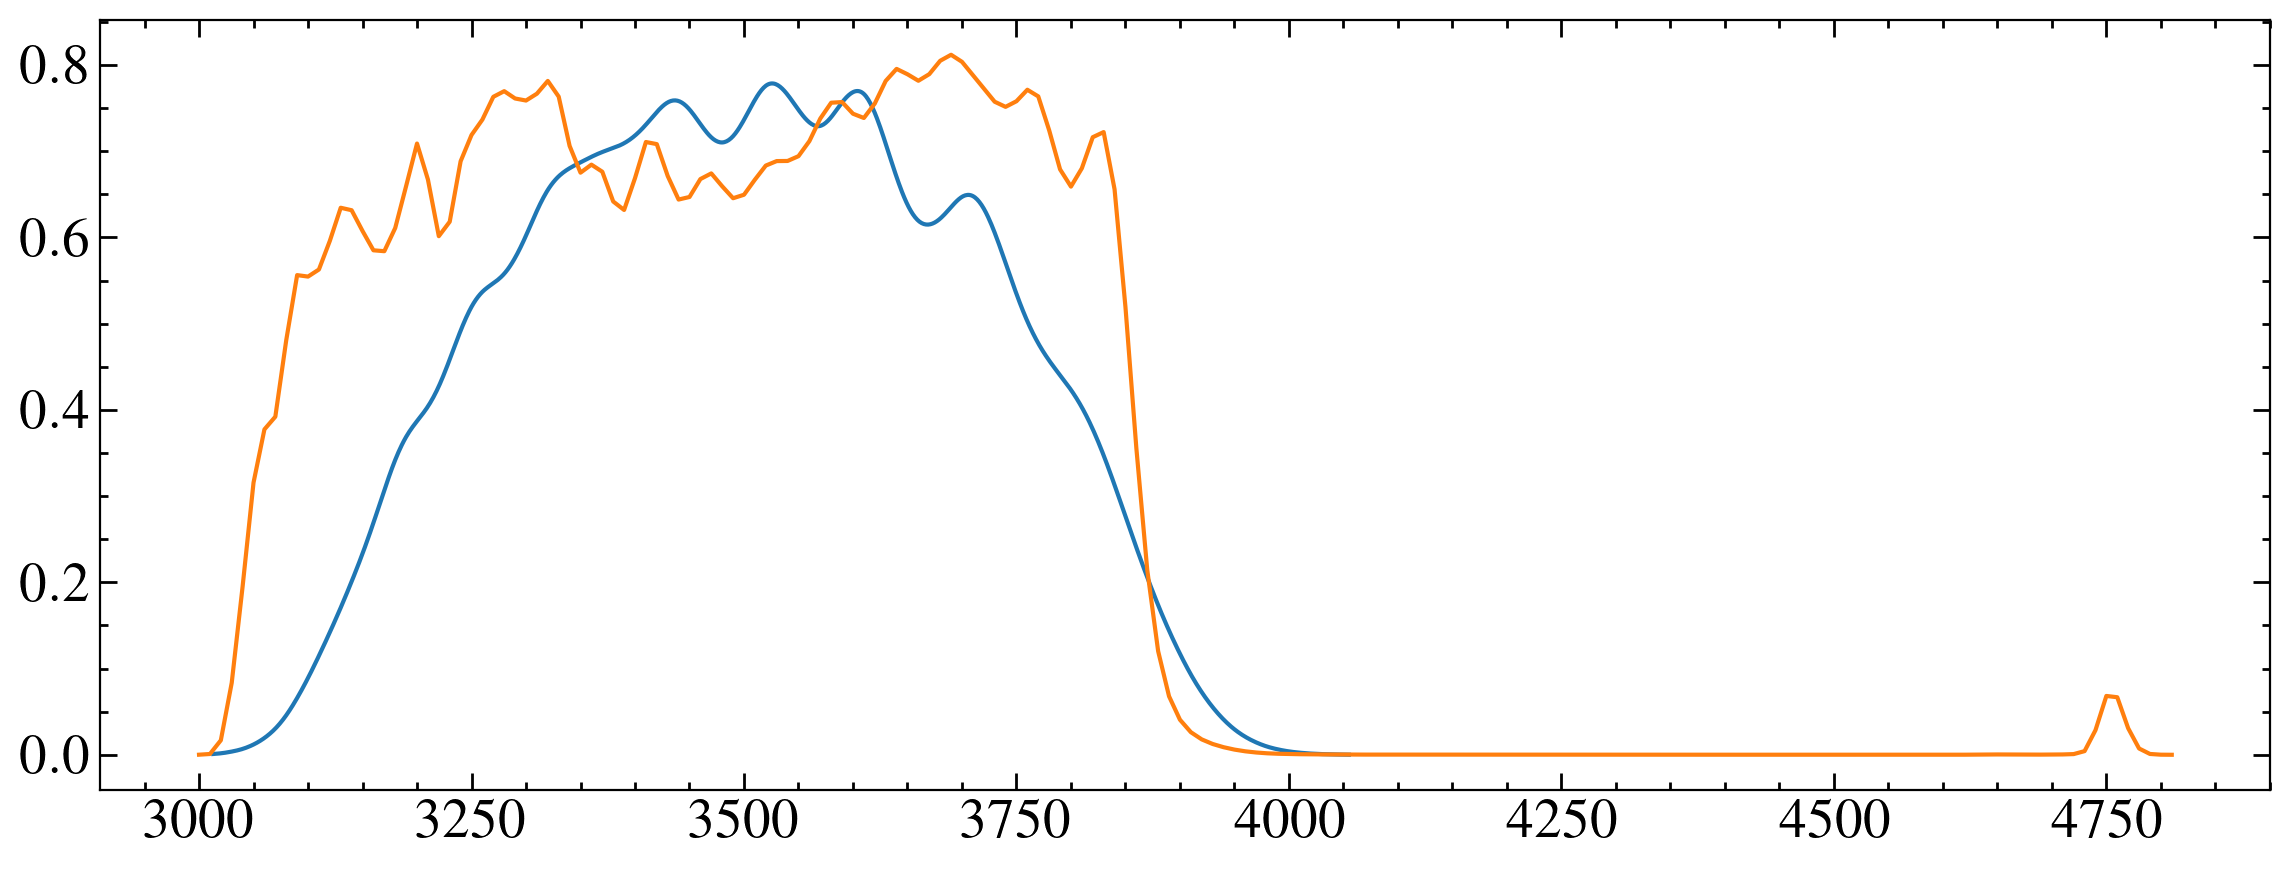

In [84]:
uw, up = np.loadtxt('/home/david/work/filters/sdss/prime/SLOAN_SDSS.uprime_filter.dat', unpack=True)
plt.plot(uw, up)
uw, up = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.U_trn.dat', unpack=True)
plt.plot(uw, up)


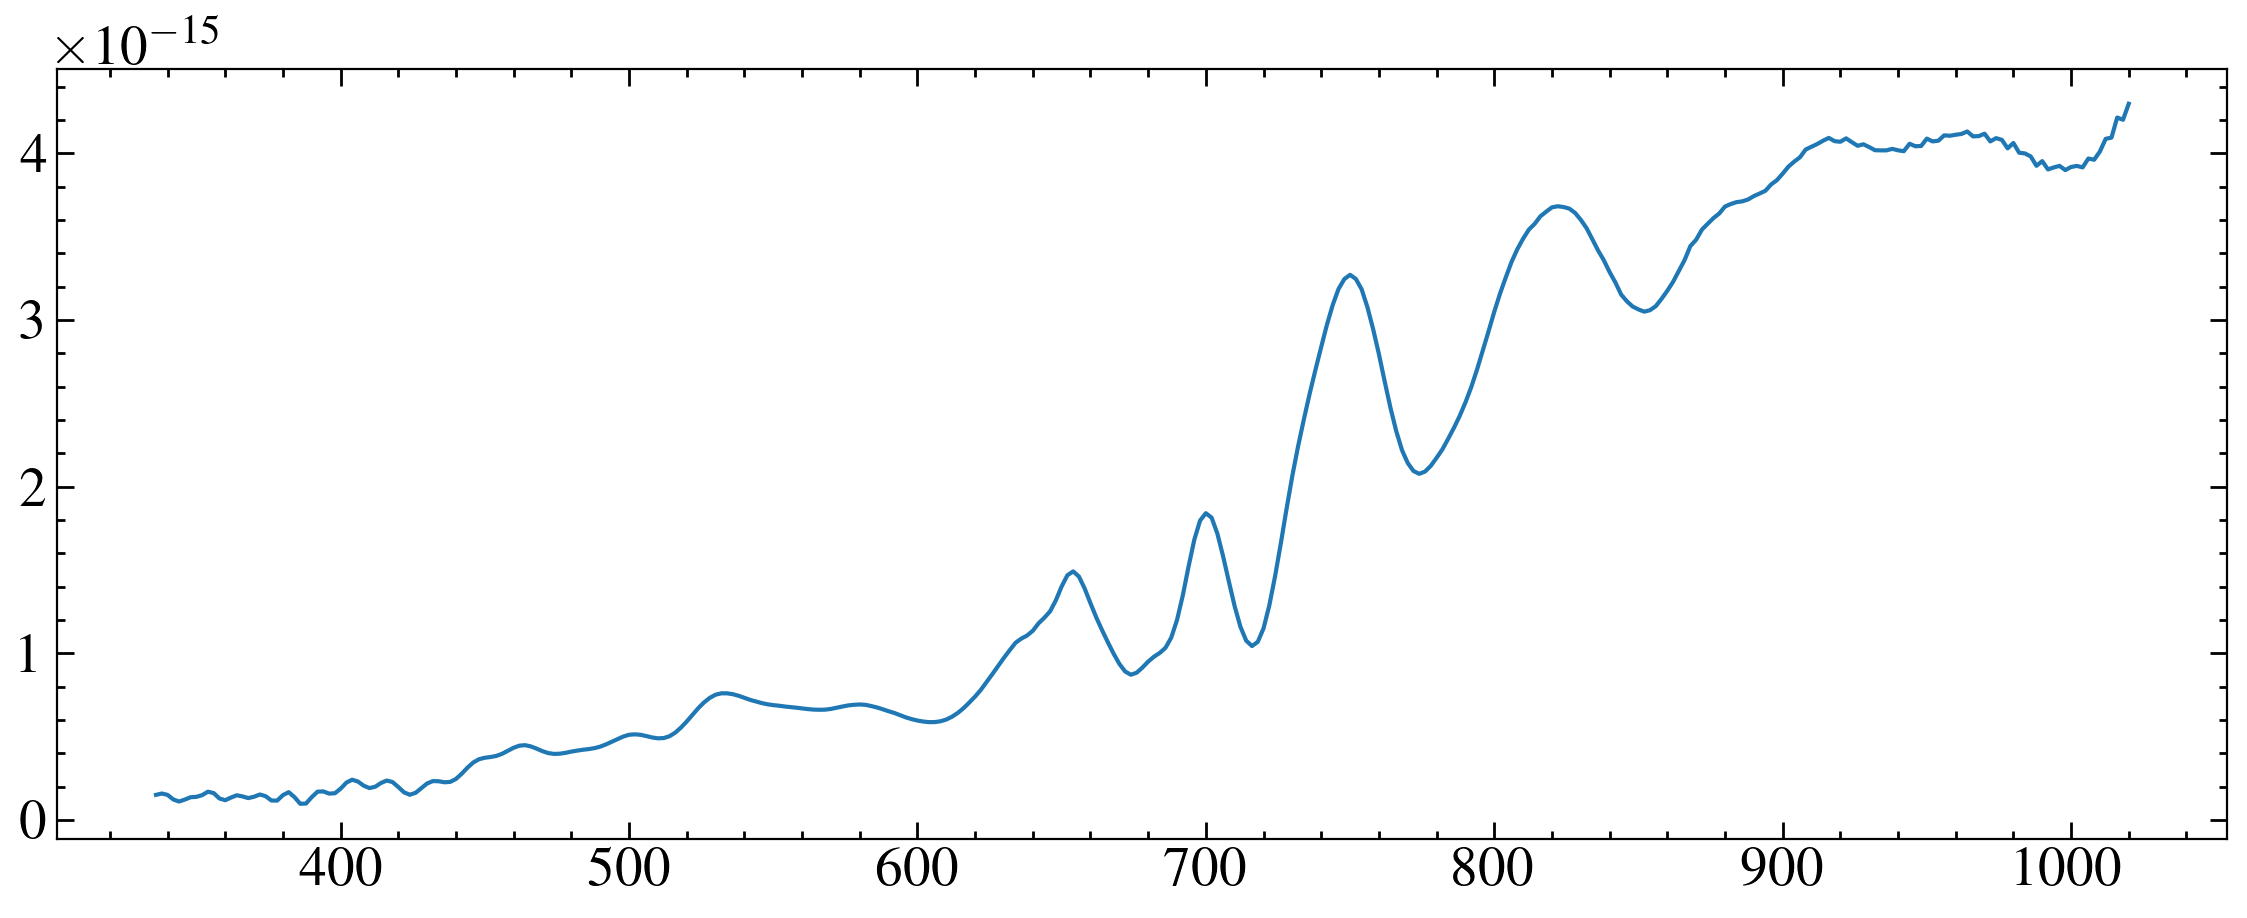

In [85]:
gaia = Table.read('data/gaiadr3_sampled_mean_spectra_1355264565043431040.vot')
plt.plot(gaia['wavelength'], gaia['flux'])

In [86]:
gaia

type,wavelength,flux,flux_error
,nm,W / (m2 nm),
object,float64,float32,float32
XP,336.0,1.5136446e-16,3.748029e-17
XP,338.0,1.5953564e-16,2.790904e-17
XP,340.0,1.5114598e-16,2.2418926e-17
XP,342.0,1.2354582e-16,1.958952e-17
XP,344.0,1.1142852e-16,1.826131e-17
XP,346.0,1.231983e-16,1.80776e-17
...,...,...,...
XP,1010.0,4.010861e-15,1.02729625e-16


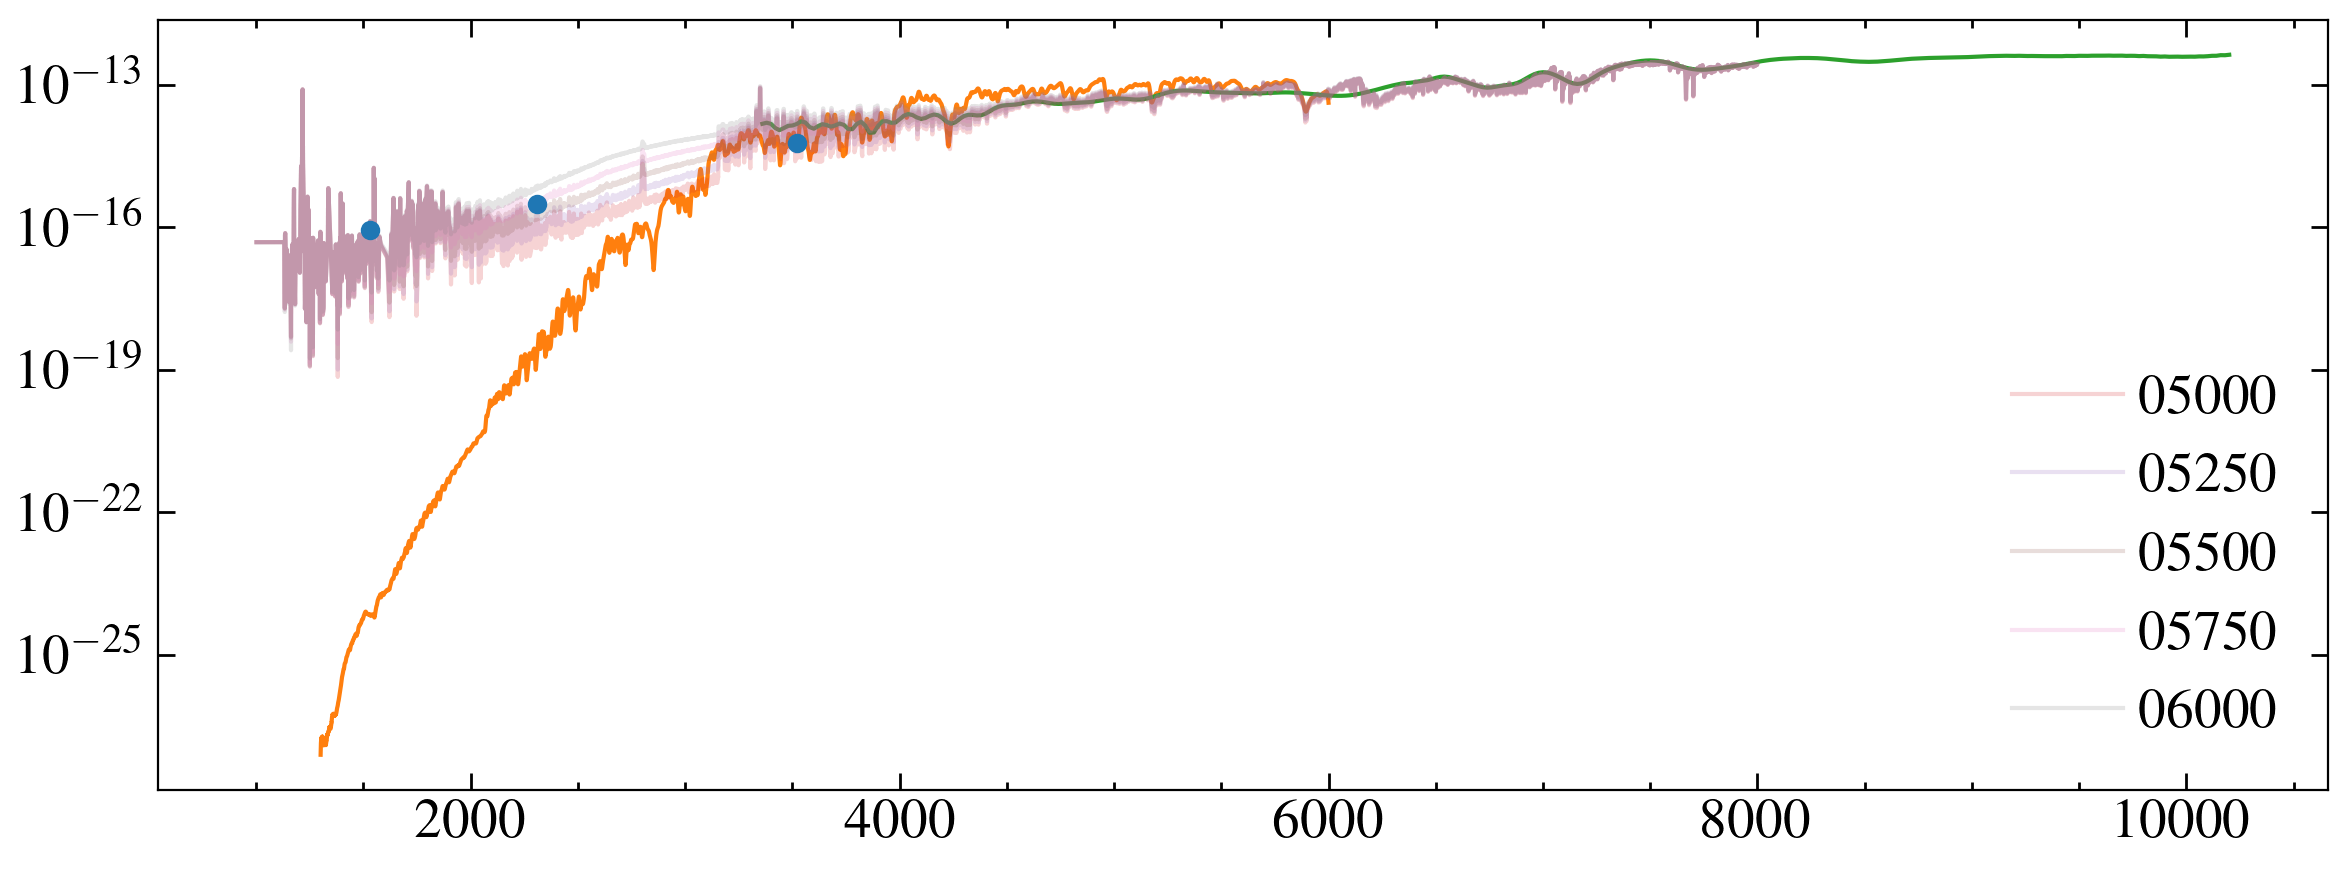

In [87]:
fig, ax = plt.subplots()

pmask = (pw > 1300) & (pw < 6000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')



ax.plot(pwi, pfi)

ax.plot(gaia['wavelength']*10, gaia['flux']*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA))
for model in mods[0:5]:
    tmod = os.path.split(model)[1][2:7]
    mw, mf = np.loadtxt(model, unpack=True)
    wdmask =  (mw > 1300) & (mw < 6000)
    mw, mf = mw[wdmask], mf[wdmask]*wd_scale
    mfi = interp1d(mw, mf, fill_value='extrapolate')(pwi)
    mfi = mfi+pfi
    mfi = interp1d(mw, mf, fill_value='extrapolate')(dmw1)
    mfi = mfi+(dmf1*scale)
    
    
    ax.plot(dmw1, mfi, alpha=0.2, label = tmod)
    # ax.plot(mw[wdmask], mf[wdmask]*wd_scale, alpha=0.2)
# ax.plot(dmw1, dmf1*scale)

ax.legend()

ax.set_yscale('log')


Ok so the problem is in the U band measurement. Rescale the proxy to Gaia? Got some Swift time

In [88]:
print(phot_w)
print(phot_f)
print(phot_e)

[1530. 2310. 3520.] Angstrom
[8.96470249e-17 3.06191581e-16 6.04888579e-15] erg / (Angstrom cm2 s)
[3.45781382e-17 2.69673319e-17 2.41955432e-17] erg / (Angstrom cm2 s)


In [89]:
import gPhoton

In [90]:
skypos = [257.383, 43.680]


In [91]:
# nuv_exps = gPhoton.gFind(band='NUV', skypos=skypos)

In [92]:
# fuv_exps = gPhoton.gFind(band='FUV', skypos=skypos)

In [93]:
target = 'g203-47'
step_size = 20.
phot_rad = 0.0045
ap_in = 0.0050
ap_out = 0.0060

In [94]:
# # nuv_photon_events = gPhoton.gAperture(band='NUV', skypos=skypos, stepsz=step_size, radius=phot_rad, 
# #                                       annulus=[ap_in, ap_out], verbose=3, csvfile='galex/{}_nuv_{}s_lc.csv'.format(target, step_size),
# #                                       overwrite=True)
# nuv_photon_events = gPhoton.gAperture(band='NUV', skypos=skypos, radius=phot_rad, 
#                                       annulus=[ap_in, ap_out], verbose=3, csvfile='galex/{}_nuv_all_lc.csv'.format(target),
#                                       overwrite=True)

In [95]:
# # print(nuv_photon_events['flux_bgsub'], nuv_photon_events['flux_bgsub_err'])

# weights = 1/(nuv_photon_events['flux_bgsub_err']**2)
# flux = np.average(nuv_photon_events['flux_bgsub'], weights= weights)
# err =  (1 / np.sum(weights))**0.5

# print(flux, err)

In [96]:
# fuv_photon_events = gPhoton.gAperture(band='FUV', skypos=skypos, stepsz=step_size, radius=phot_rad, 
# #                                       annulus=[ap_in, ap_out], verbose=3, csvfile='galex/{}_fuv_{}s_lc.csv'.format(target, step_size),
# #                                       overwrite=True)

# fuv_photon_events = gPhoton.gAperture(band='FUV', skypos=skypos, radius=phot_rad, 
#                                       annulus=[ap_in, ap_out], verbose=3, csvfile='galex/{}_fuv_all_lc.csv'.format(target, step_size),
#                                       overwrite=True)

In [97]:
# print(fuv_photon_events['flux_bgsub'], fuv_photon_events['flux_bgsub_err'])

# weights = 1/(fuv_photon_events['flux_bgsub_err']**2)
# flux = np.average(fuv_photon_events['flux_bgsub'], weights= weights)
# err =  (1 / np.sum(weights))**0.5

# print(flux, err)

3.926286076329794e-16
2.026535152276017e-16


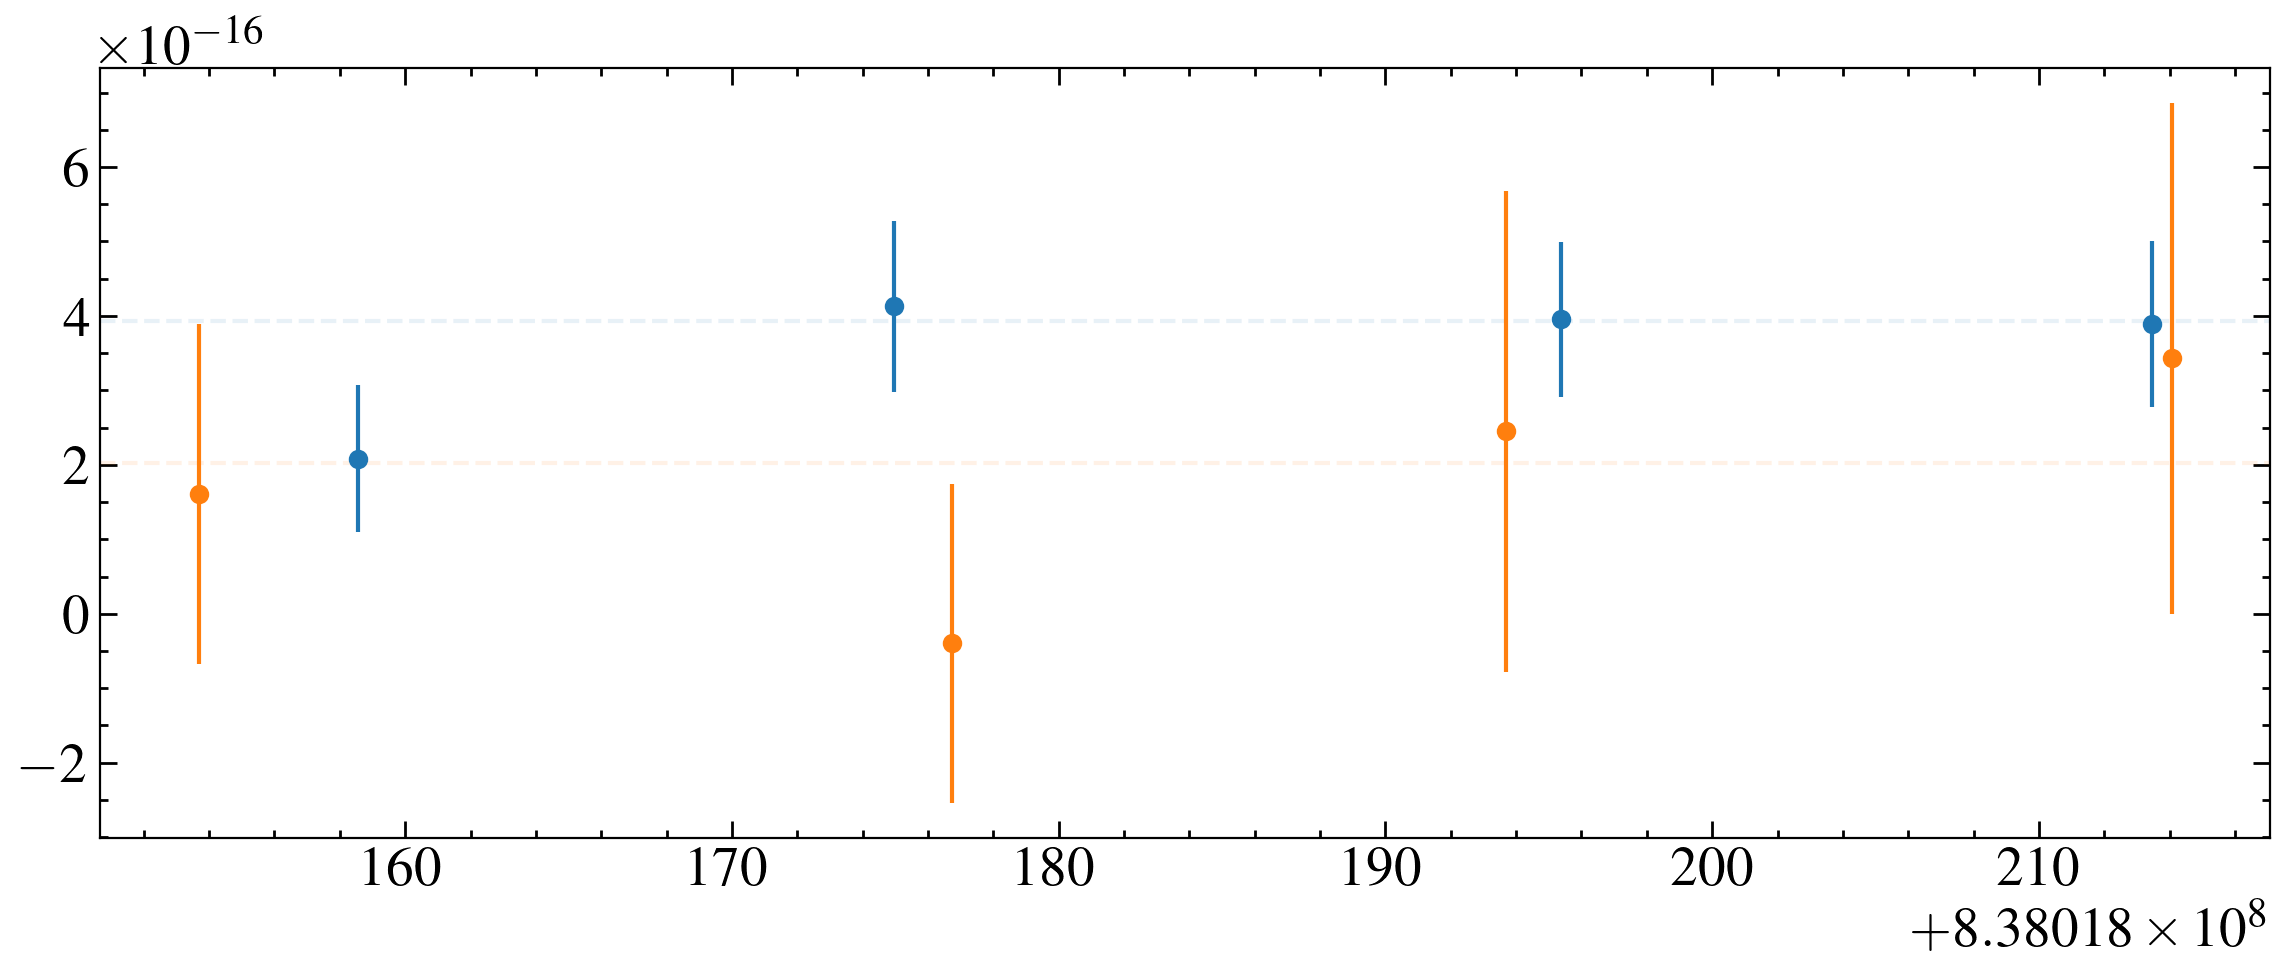

5.296533325507314e-16
7.592421611946143e-17


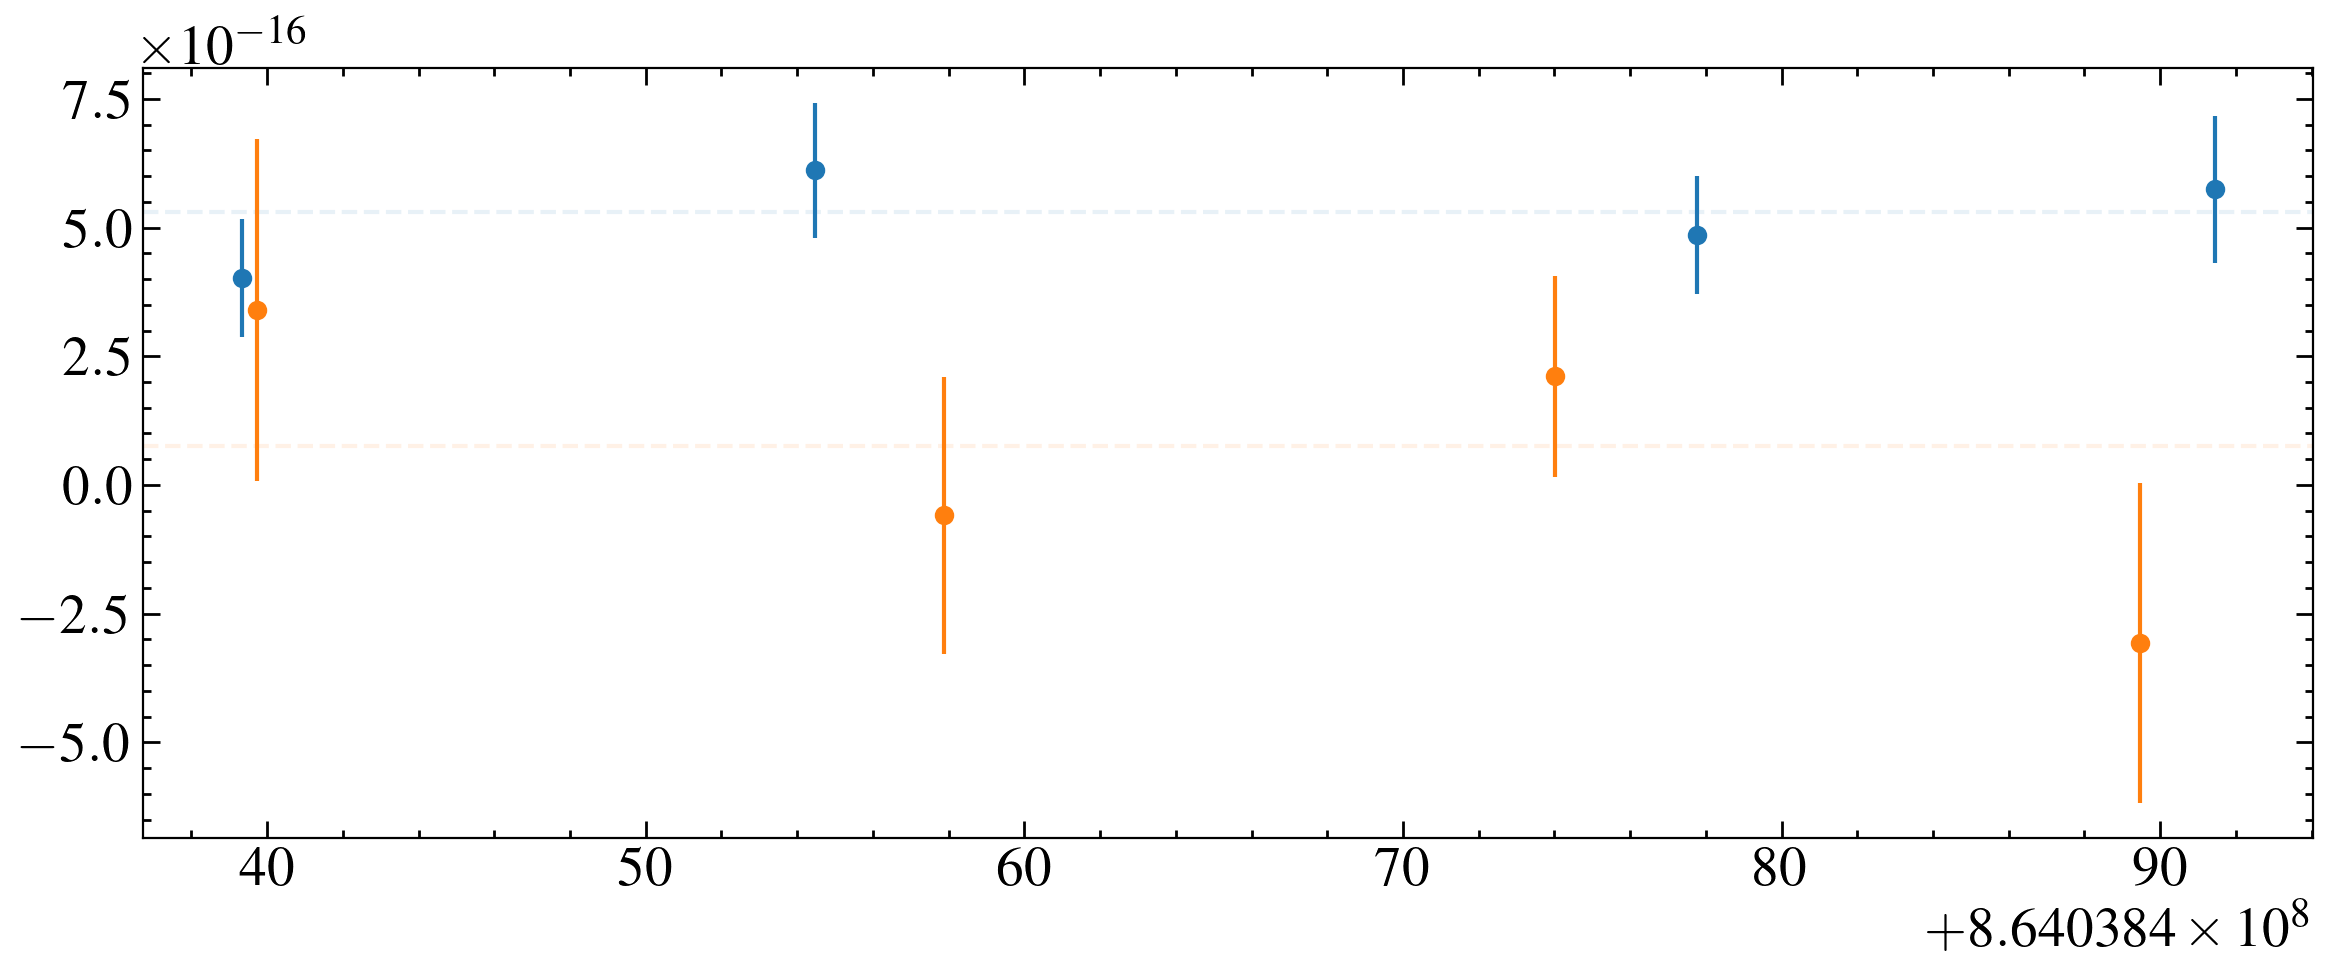

In [98]:
nuv= Table.read('galex/{}_nuv_{}s_lc.csv'.format(target, step_size))
fuv= Table.read('galex/{}_fuv_{}s_lc.csv'.format(target, step_size))

t, f, e, q = nuv['t_mean'], nuv['flux_bgsub'], nuv['flux_bgsub_err'], nuv['flags']
tf, ff, ef, qf = fuv['t_mean'], fuv['flux_bgsub'], fuv['flux_bgsub_err'], fuv['flags']
# t, f, e = t[q==0], f[q==0], e[q==0]
#plt.errorbar(t-t[0], f, yerr=e, ls='none', marker='o')
t0s, t1s = nuv_exps['NUV']['t0'], nuv_exps['NUV']['t1']
for t0, t1 in zip(t0s, t1s):
    mask = (t >=t0-100) & (t <=t1+100)
    fmask = (tf >=t0-100) & (tf <=t1+100)
    print(np.median(f[mask]))
    plt.axhline(np.median(f[mask]), ls='--', c='C0', alpha=0.1)
    plt.axhline(np.median(ff[fmask]), ls='--', c='C1', alpha=0.1)
    print(np.median(ff[fmask]))
    plt.errorbar(t[mask], f[mask], yerr=e[mask], ls='none', marker='o')
    plt.errorbar(tf[fmask], ff[fmask], yerr=ef[fmask], ls='none', marker='o')
#     plt.xlim(t0-20, t0+1397.)
    plt.show()
   # if (t1 - t0) > 900:
#     lc = lk.LightCurve(time=t[mask]*u.s, flux=f[mask], flux_err=e[mask])
#     pg = lc.to_periodogram(oversample_factor= 10, minimum_period=20*u.s, maximum_period=200*u.s)
#     plt.plot(pg.period.to(u.s), pg.power)
#     print(pg.period_at_max_power.to(u.s))
    plt.show()

Aperture size? insignificant

In [99]:
# rads = np.arange(0.004, 0.008, 0.0005)
# fluxes = []
# errs = []
# for rad in rads:
#     ap_in = rad +0.005
#     ap_out = rad +0.015

#     fuv_photon_events = gPhoton.gAperture(band='FUV', skypos=skypos, radius=rad, 
#                                           annulus=[ap_in, ap_out], verbose=0)
    
#     weights = 1/(fuv_photon_events['flux_bgsub_err']**2)
#     flux = np.average(fuv_photon_events['flux_bgsub'], weights= weights)
#     err =  (1 / np.sum(weights))**0.5
#     fluxes.append(flux)
#     errs.append(err)
    
    
    
# plt.errorbar(rads, fluxes, yerr = errs, marker='o', ls='none')

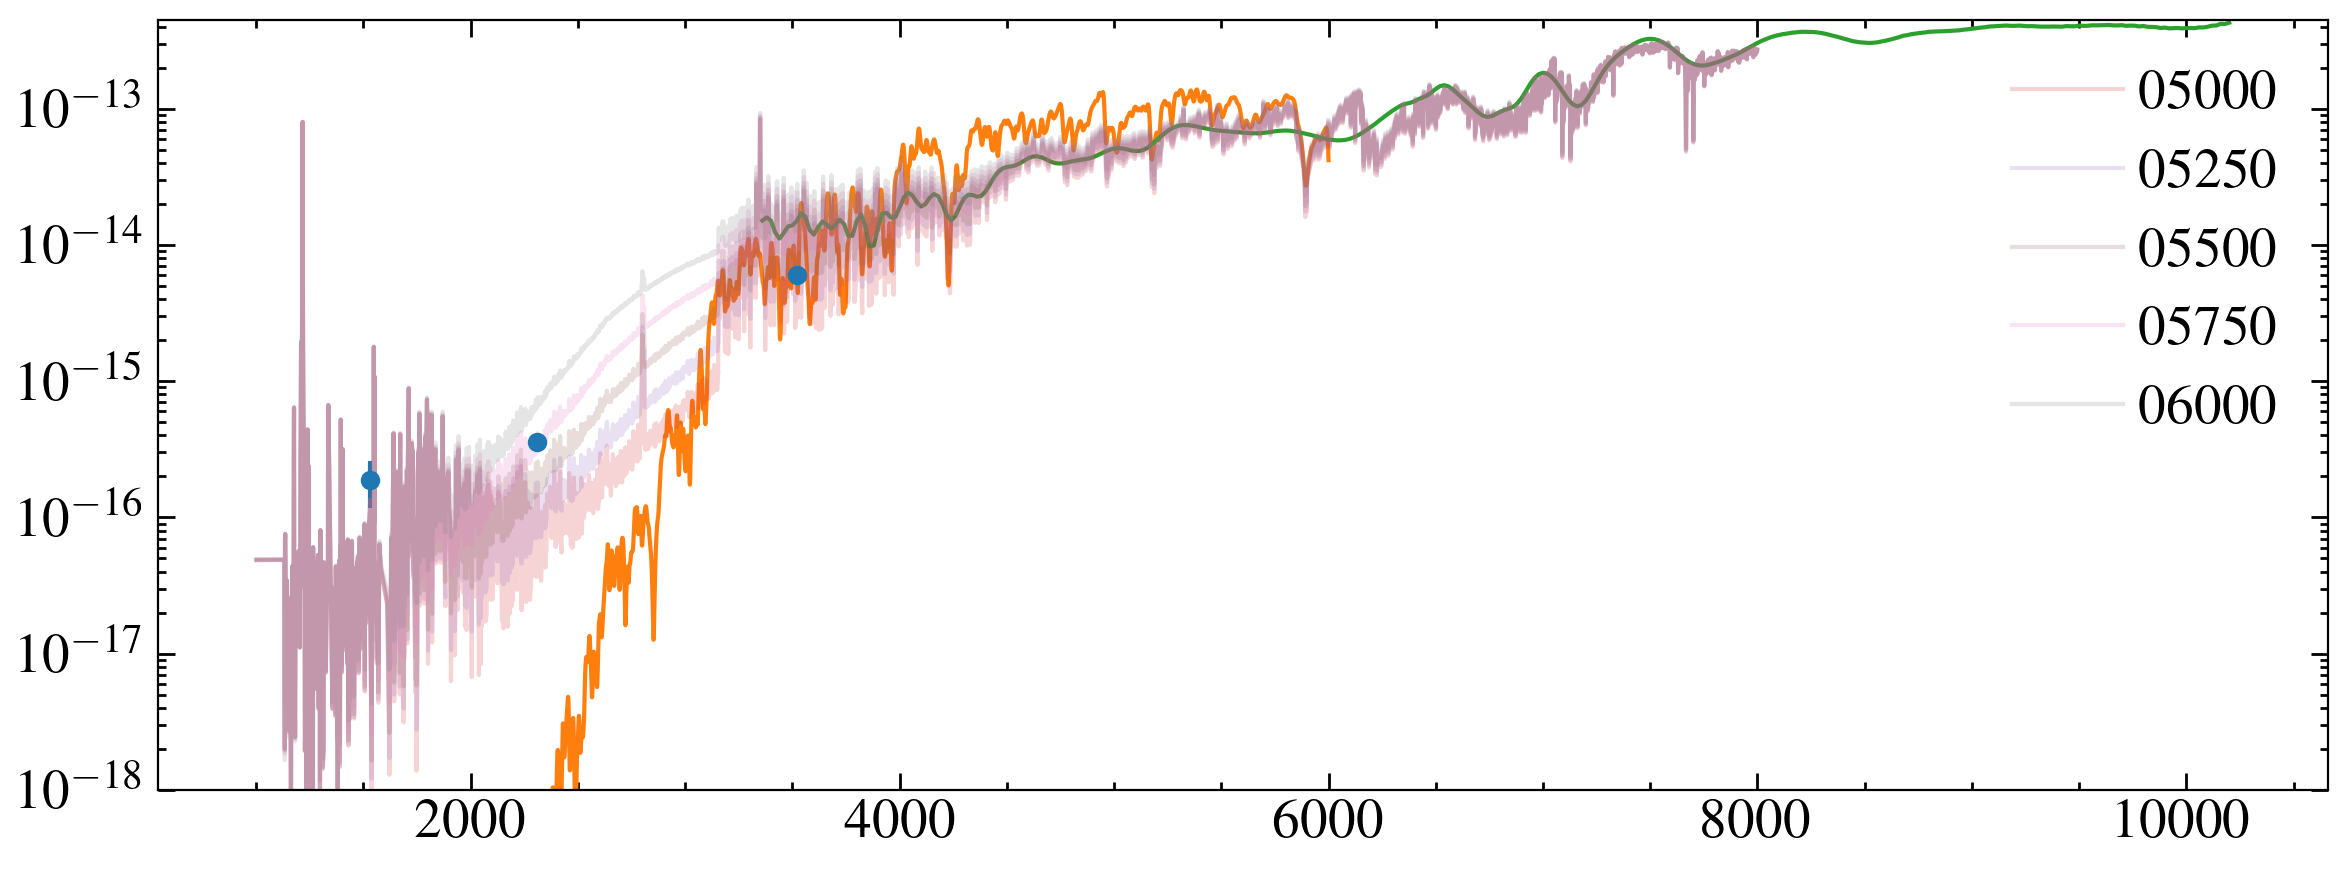

In [100]:
fig, ax = plt.subplots()

pmask = (pw > 1300) & (pw < 6000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


#with updated galex
phot_w = [1530, 2310, 3520,]

 
phot_f = [1.8820923094427784e-16, 3.557310200972079e-16, 6.04888579e-15] 
phot_e = [7.080414587154201e-17,3.2290504470423134e-17, 2.41955432e-17]

ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')
 




ax.plot(pwi, pfi)

ax.plot(gaia['wavelength']*10, gaia['flux']*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA))
for model in mods[0:5]:
    tmod = os.path.split(model)[1][2:7]
    mw, mf = np.loadtxt(model, unpack=True)
    wdmask =  (mw > 1300) & (mw < 6000)
    mw, mf = mw[wdmask], mf[wdmask]*wd_scale
    mfi = interp1d(mw, mf, fill_value='extrapolate')(pwi)
    mfi = mfi+pfi
    mfi = interp1d(mw, mf, fill_value='extrapolate')(dmw1)
    mfi = mfi+(dmf1*scale)
    
    
    ax.plot(dmw1, mfi, alpha=0.2, label = tmod)
    # ax.plot(mw[wdmask], mf[wdmask]*wd_scale, alpha=0.2)
# ax.plot(dmw1, dmf1*scale)

ax.legend()
ax.set_ylim(1e-18)

ax.set_yscale('log')


Looks like 5750K works with or without the proxy

In [101]:
mods

['/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05250_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05500_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05750_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06250_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06500_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06750_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da07000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da07250_800.dk.

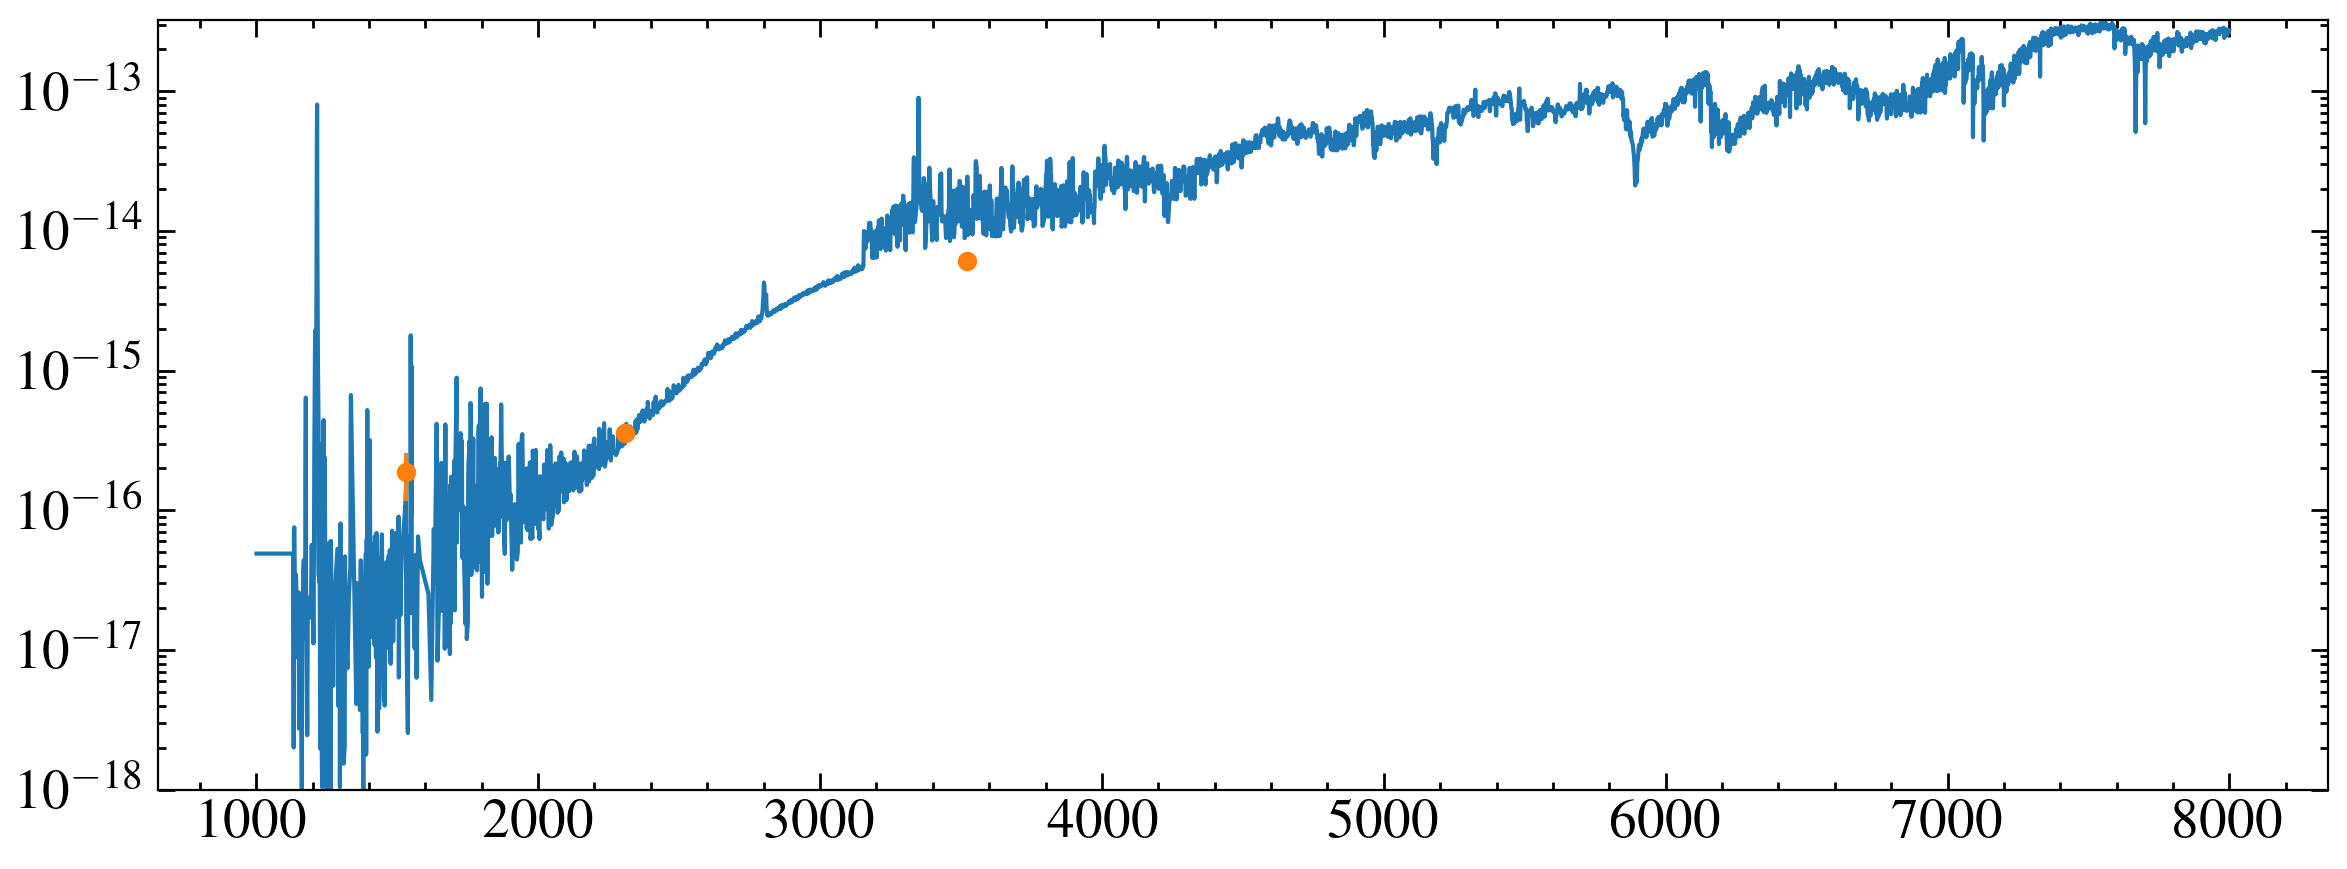

In [108]:
fig, ax = plt.subplots()

mw, mf = np.loadtxt(mods[3], unpack=True)
wdmask =  (mw > 1000) & (mw < 6000)
mw, mf = mw[wdmask], mf[wdmask]*wd_scale
mfi = interp1d(mw, mf, fill_value='extrapolate')(dmw1)
mfi = mfi+(dmf1*scale)
ax.plot(dmw1, mfi, label = tmod)
ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')

ax.set_ylim(1e-18)

ax.set_yscale('log')

new_mod = Table([dmw1, mfi], names =['#WAVELENGTH', 'FLUX'])
ascii.write(new_mod, 'g203_model.dat', format='basic')